In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

Precompiling packages...
  14070.3 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 17 seconds. 520 already precompiled.


In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions, StatsBase
using FreqTables

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [4]:
# can add a copy of example_do_rg_run if we need more flexibility

# Testing

In [4]:
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end

sigma_to_mu_ratio1 (generic function with 1 method)

In [40]:
Ns = Nr = 30

total_influx = 10. * Ns
sparsity_influx = 0.1
Kmean = total_influx / (sparsity_influx * Nr)
K = (Kmean, Kmean * sigma_to_mu_ratio1())

rsg = RSGJans1(Ns, Nr;
    r=1.,
    m=0.4 .* (1., sigma_to_mu_ratio1()),
    
    sparsity_influx, K,
    
    c=2. .* (1., sigma_to_mu_ratio1()),
    l=0.5 .* (1., sigma_to_mu_ratio1()),
    
    sparsity_resources=0.1,
    num_byproducts=2,
    
    Ds=1e-8, Dr=1.,
)

# @time rslts, params, params_sss = example_do_rg_run2(rsg, nthreads(), 100., 1000;
#     extinctthr=1e-12,
#     return_int=c->abs(c)!=101,
#     return_int_sss=true,
#     maxresidthr=1e-12,
#     abstol=1e-15, reltol=1e-15,
#     maxiters=100000,
# )
# countmap(rslts)

RSGJans1{Normal{Float64}, Dirac{Float64}, Dirac{Float64}, Dirac{Float64}, Dirac{Int64}, Normal{Float64}, Dirac{Int64}, Dirac{Int64}, Normal{Float64}, Normal{Float64}}(30, 30, Normal{Float64}(μ=0.4, σ=0.1132342533616419), Dirac{Float64}(value=1.0), Dirac{Float64}(value=1.0e-8), Dirac{Float64}(value=1.0), Dirac{Int64}(value=3), Normal{Float64}(μ=100.0, σ=28.308563340410476), Dirac{Int64}(value=3), Dirac{Int64}(value=2), Normal{Float64}(μ=2.0, σ=0.5661712668082095), Normal{Float64}(μ=0.5, σ=0.14154281670205238), nothing)

In [6]:
count(params_sss[1][1:Ns] .> 1e-10)

1

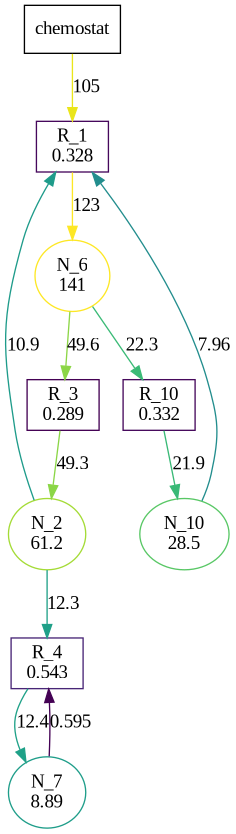

In [16]:
g = diagram_sfss_v3(collect(zip(params, params_sss))[3]...;
    strain_threshold=1e-5,
    # edge_threshold=1e-12
)

In [456]:
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

# Running a single system

In [43]:
ps = rsg();

In [17]:
ps = params[3];

## No space solver

In [18]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps()
);
maximum(abs, sss.resid)

  1.679972 seconds (833.57 k allocations: 102.624 MiB, 8.37% compilation time)


3.397259117631966e-14

In [48]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000);
p = remake_guarantee_positive(p)

@time s = solve(p, QNDF())

# f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
# f

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


retcode: MaxIters
Interpolation: 3rd order Hermite
t: 411505-element Vector{Float64}:
   0.0
   4.3778919803802e-11
   4.81568117841822e-10
   4.859460098222022e-9
   4.863837990202402e-8
   4.86427577940044e-7
   4.864319558320245e-6
   4.864323936212225e-5
   0.000251430351171493
   0.00045421746298086375
   0.000882011330052923
   0.0015987462417922076
   0.0023154811535314925
   ⋮
 144.545024325028
 144.54502945573063
 144.54503971713586
 144.54504382169796
 144.54505203082215
 144.54505531447182
 144.54506188177118
 144.54507501636988
 144.54508027020935
 144.54509077788833
 144.54509498095993
 144.5451033871031
u: 411505-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9999999999888766, 0.9999999999854353, 0.9999999999932625, 0.9999999999825935, 0.9999999999938791, 0.9999999999877432, 0.9999999999866875, 0.9999999999821296, 0.9999999999784911, 0.9999999999872279  …  5.677635123193378e-30,

## Spatial stuff

In [29]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 7.827782735324402e-15


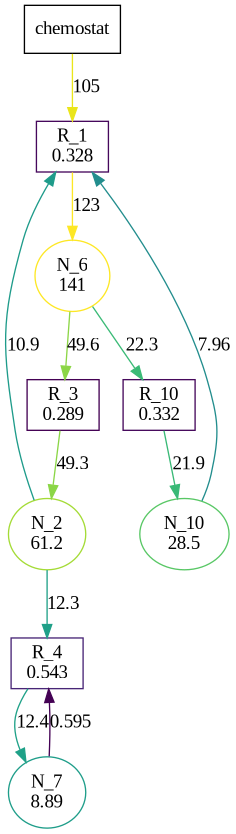

In [30]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10
)

### Linear stability

In [418]:
ks = LinRange(0., 1000., 10000)

Ds = get_Ds(ps)
Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1e-8, get_Ns(ps)[2])
)
Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-5.464753751148015e-5

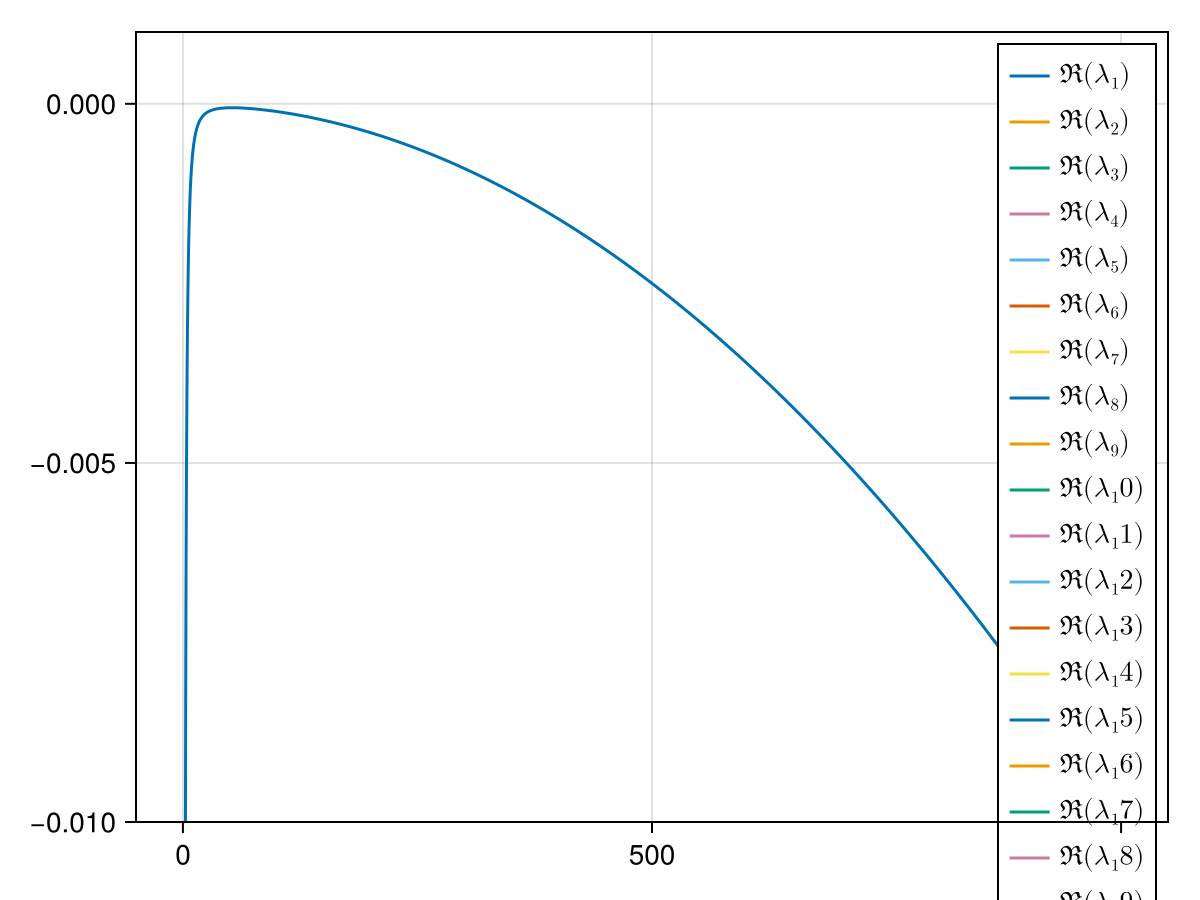

In [419]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


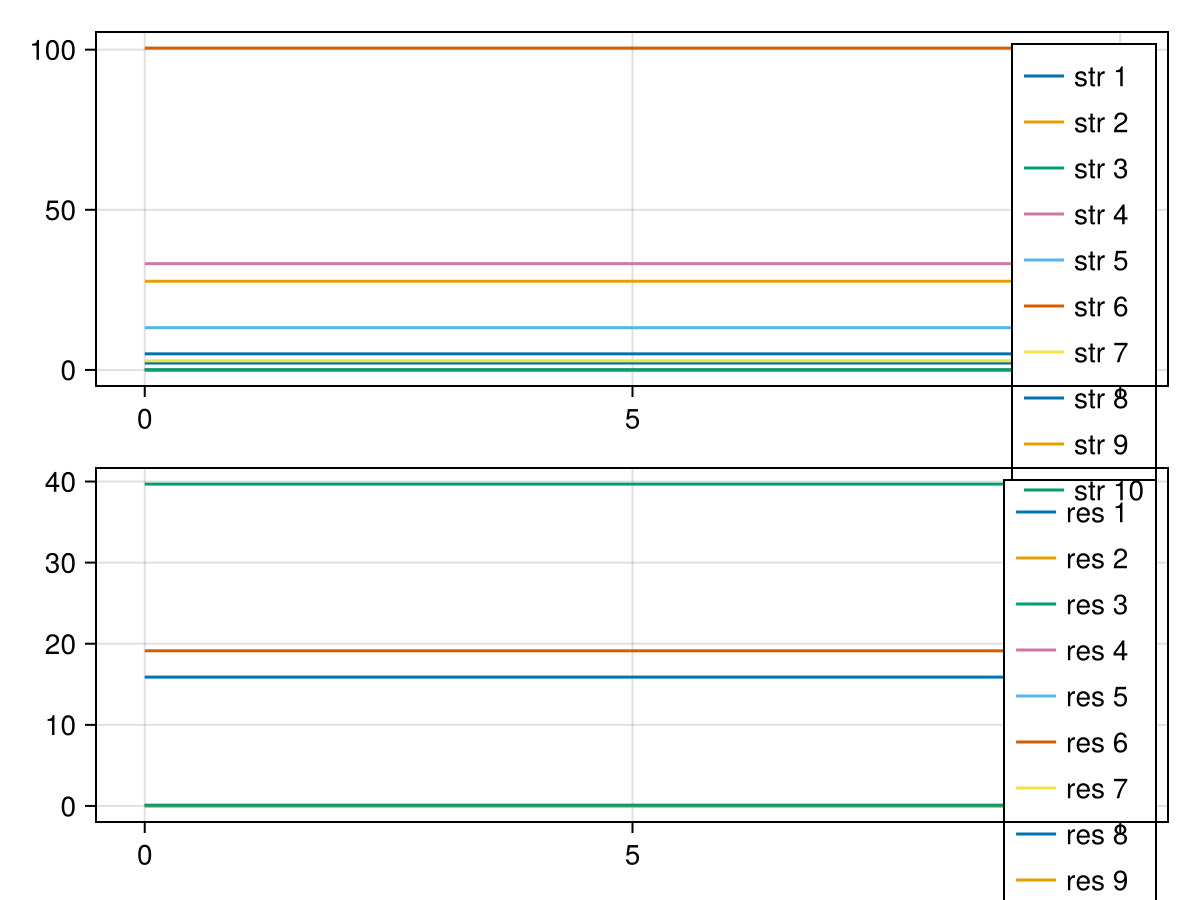

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

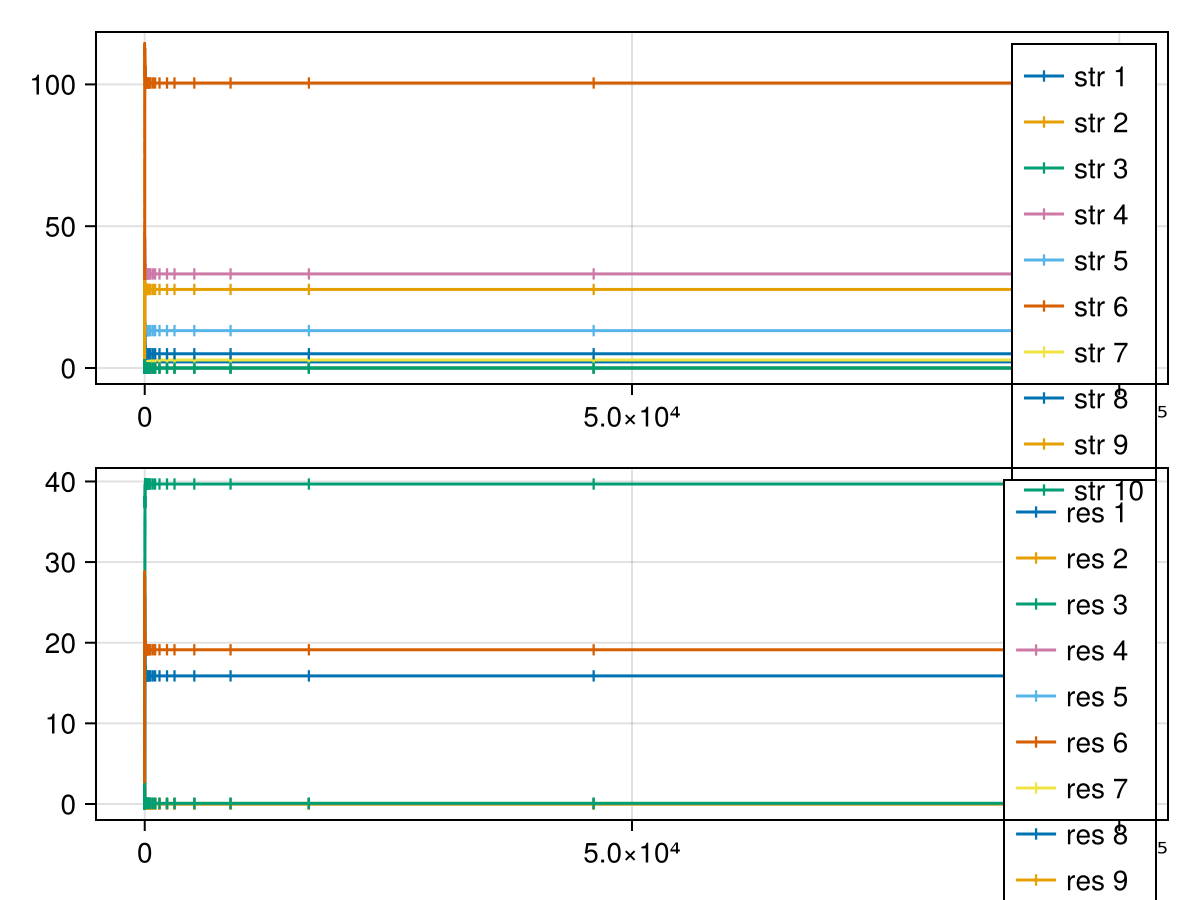

In [353]:
plot_smmicrm_sol_avgs(sps)

# Things I want to save for reference!

## What I thought gave many instabilities but wat just k=0 ~ 1e-10

In [213]:
rsg = RSGJans1(20, 20;
    m=0.9, # increasing m we quickly lose them!
    r=0.2,
    Kp=0.2, K=0.5,
    
    c=4.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)
@time xx = example_do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.000020 seconds (153 allocations: 92.625 KiB)
  2.313998 seconds (26.95 M allocations: 4.488 GiB)


1-element Named Vector{Int64}
Dim1  │ 
──────┼────
1     │ 100

In [106]:
@time yy = example_do_rg_run(rsg, 1, LinRange(0., 100., 1000),
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6,
    return_interesting=true
)
@show length(yy[2])
freqtable(yy[1])

Generating one params: 0.000012 seconds (42 allocations: 12.844 KiB)
  0.012593 seconds (48.18 k allocations: 35.942 MiB)
length(yy[2]) = 0


1-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 1

In [88]:
ps = yy[2][1];

# Bigger runs

In [114]:
bigrsg = RSGJans1(50, 50;
    m=1.,
    r=1.,
    Kp=0.1, K=10.0,
    
    c=(2., 1.),
    l=0.2,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)

@time xx = do_rg_run(rsgj, 1000, LinRange(0., 1000., 1000);
    extinctthreshold=1e-5
)

jldsave(datadir("randomsystems/prelim", randname()*".jld2");
    rsg=bigrsg,
    output=xx
)

freqtable(xx)

Generating one params: 0.000501 seconds (865 allocations: 1.265 MiB)
451.332197 seconds (3.80 G allocations: 174.887 GiB, 4.30% gc time, 0.00% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │  14
1     │ 985
2     │   1

## Looking/comparing saved data

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()